# Project 3 - Reddit Classification Problem

## Problem Statement
_____________________________________________________

The app 'Seedly' is known to help users make smarter financial decisions with its expense tracking app, they have planned to further expand the community to include legal expertise/advice to help individuals with legal woes.

Their aim is to curate articles about legal matters and finance by using reddit to classify posts that are posted in subreddit personal finance and legal advice.

This is will give them a sense of what people are generally asking or posting about to create articles based on general population.

## Executive Summary
_________________________________________________
1. [Data Scraping](#Chapter1) 
- Sources derived from Reddit Pushift API based scraping from 2 subreddits, both need to hit a minimum of 5000 posts and each post to contained 20 words and more.
Posts with empty contents and emojis to be discared.
Subreddits chosen was r/personalfinance and r/legaladvice


2. [EDA](#Chapter2) 
- Appending title and selftext into 1 column and dropping duplicates and posts that have less than 20 words.
After appending the columns, the subreddit column consists of NaN values this was then filled in.
After cleaning up the following, the 2 dataframes then was merged to create a single dataframe for the next steps.

3. [Pre-Processing & Modelling](#Chapter3)
- Countvectorizer with stopwords hyperparameter was used to convert text data into a structured numeric df. 
TfidrVectorizer was also used to compared against the countvectorizer to see if there's a difference. 

4. [Evaluation](#Chapter4)
- We evaluate the metrics of the chosen model which is the MultiNomial Naive Bayes that we have chosen by creating a matrix table to compare and make comparisons of the different metrics.

5. [Conclusion](#Chapter5)
- To conclude the findings from the model, and to introduce ways to improve future models based on our analysis thus far.

## 1. Data Scraping <a class="anchor" id="Chapter1"></a>
_____________________________________________________________

In [301]:
import time
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier



from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [84]:
""""
def get_posts(subreddit, number=5000):
    url = 'https://api.pushshift.io/reddit/search/submission'
    params = {
        'subreddit': subreddit,
        'size': 100
        
    } # 'before' is added later in the while loop
    df = pd.DataFrame() # empty dataframe for concatenating
    returned = pd.DataFrame()
    while True: # Need a break out of this
        time.sleep(3)
        
        res = requests.get(url, params)
        data = res.json()
        posts = data['data']
        df = pd.DataFrame(posts)
        params['before'] = df.iloc[-1:,:]['created_utc']
        returned = pd.concat([returned, df[['subreddit','selftext','title']]], axis=0)
        returned.drop_duplicates(inplace=True)
        
        if len(returned) > number:
            break
            
    returned.reset_index(inplace=True,drop=True)
    return returned[:number]
""""

### r/PersonalFinance

In [ ]:
pf_df = get_posts('personalfinance', 7000) 

In [ ]:
pf_df

In [ ]:
pf_df.isnull().sum()

In [ ]:
pf_df[pf_df.selftext.isnull()]

In [ ]:
pf_df = pf_df[['subreddit','selftext']].append(pf_df[['title']].set_axis(['selftext'], axis=1)).reset_index(drop=True)

In [ ]:
pf_df.to_csv('personalfinance.csv', index=False)

In [ ]:
pf_df

### r/LegalAdvice

In [ ]:
la_df = get_posts('legaladvice', 7000)

In [ ]:
la_df

In [ ]:
la_df = la_df[['subreddit','selftext']].append(la_df[['title']].set_axis(['selftext'], axis=1)).reset_index(drop=True)

In [ ]:
la_df.isnull().sum()

In [ ]:
la_df[la_df.selftext.isnull()]

In [ ]:
la_df

In [ ]:
la_df.to_csv('legaladvice.csv', index=False)

## 2. EDA <a class="anchor" id="Chapter2"></a>
_________________________________________________________

In [255]:
personalfinance = pd.read_csv('personalfinance.csv')

In [256]:
personalfinance.head()

,subreddit,selftext
0,personalfinance,"I have a handful of various collections, and n..."
1,personalfinance,"By all in one, I mean a bank that offers a dec..."
2,personalfinance,[removed]
3,personalfinance,"My goal this year was to open a Roth IRA, I've..."
4,personalfinance,I keep seeing great rates on CDs but should I ...


In [257]:
personalfinance.shape

(14000, 2)

In [258]:
personalfinance.drop_duplicates(subset='selftext', inplace=True)

In [259]:
personalfinance.isnull().sum()

subreddit    6968
selftext        1
dtype: int64

In [260]:
personalfinance.subreddit.fillna(value='personalfinance', inplace=True)

In [261]:
personalfinance.isnull().sum()

subreddit    0
selftext     1
dtype: int64

In [262]:
personalfinance = personalfinance[personalfinance['selftext'].str.split().str.len().gt(20)]
print(personalfinance)

             subreddit                                           selftext
0      personalfinance  I have a handful of various collections, and n...
1      personalfinance  By all in one, I mean a bank that offers a dec...
3      personalfinance  My goal this year was to open a Roth IRA, I've...
4      personalfinance  I keep seeing great rates on CDs but should I ...
5      personalfinance  So I'm stressing out because they closed the a...
...                ...                                                ...
13938  personalfinance  I have most of my money in a chime account. I ...
13951  personalfinance  I have a call with my Mom's financial advisor ...
13956  personalfinance  Hello, I have a question regarding 3 missed pa...
13979  personalfinance  [UK] 0% Credit card for balance transfer, half...
13983  personalfinance  I just tried calling my insurance company, and...

[5963 rows x 2 columns]


In [263]:
personalfinance

,subreddit,selftext
0,personalfinance,"I have a handful of various collections, and n..."
1,personalfinance,"By all in one, I mean a bank that offers a dec..."
3,personalfinance,"My goal this year was to open a Roth IRA, I've..."
4,personalfinance,I keep seeing great rates on CDs but should I ...
5,personalfinance,So I'm stressing out because they closed the a...
...,...,...
13938,personalfinance,I have most of my money in a chime account. I ...
13951,personalfinance,I have a call with my Mom's financial advisor ...
13956,personalfinance,"Hello, I have a question regarding 3 missed pa..."
13979,personalfinance,"[UK] 0% Credit card for balance transfer, half..."


____________________________________________________

In [264]:
legaladvice = pd.read_csv('legaladvice.csv')

In [265]:
legaladvice.head()

,subreddit,selftext
0,legaladvice,I bought a house with my boyfriend about a yea...
1,legaladvice,"Hi all,\nMy 6 y/o daughter broke her left arm ..."
2,legaladvice,Third time changing jobs during FL permanent a...
3,legaladvice,"If a county changes an ordinance, after you ha..."
4,legaladvice,Working as travel nurse and they offered an as...


In [266]:
legaladvice.shape

(14000, 2)

In [267]:
legaladvice.drop_duplicates(subset='selftext', inplace=True)

In [268]:
legaladvice.subreddit.fillna(value='LegalAdvice', inplace=True)

In [269]:
legaladvice.isnull().sum()

subreddit    0
selftext     0
dtype: int64

In [270]:
legaladvice = legaladvice[legaladvice['selftext'].str.split().str.len().gt(20)]
print(legaladvice) 

         subreddit                                           selftext
0      legaladvice  I bought a house with my boyfriend about a yea...
1      legaladvice  Hi all,\nMy 6 y/o daughter broke her left arm ...
2      legaladvice  Third time changing jobs during FL permanent a...
3      legaladvice  If a county changes an ordinance, after you ha...
4      legaladvice  Working as travel nurse and they offered an as...
...            ...                                                ...
13985  LegalAdvice  My (23F) mother (40sF) somehow got access of m...
13986  LegalAdvice  If a debt I have in Oklahoma goes to a collect...
13988  LegalAdvice  If I help a lesbian couple have a child, is th...
13990  LegalAdvice  Who is legally entitled to ownership of a pet?...
13992  LegalAdvice  Company I worked for went public, used 3rd par...

[7366 rows x 2 columns]


In [271]:
legaladvice = legaladvice.drop(legaladvice.index[5964:7366])

In [272]:
legaladvice

,subreddit,selftext
0,legaladvice,I bought a house with my boyfriend about a yea...
1,legaladvice,"Hi all,\nMy 6 y/o daughter broke her left arm ..."
2,legaladvice,Third time changing jobs during FL permanent a...
3,legaladvice,"If a county changes an ordinance, after you ha..."
4,legaladvice,Working as travel nurse and they offered an as...
...,...,...
6280,legaladvice,So my sister (now 31) got married to her husba...
6281,legaladvice,Not sure if this is the right place since I'm ...
6282,legaladvice,My wife has cancer and the doctor told her to ...
6284,legaladvice,My Landlord's been pretty horrible throughout ...


In [273]:
df = pd.concat([personalfinance, legaladvice], axis=0)

In [274]:
df.to_csv('merged_df.csv', index=False)

In [275]:
df

,subreddit,selftext
0,personalfinance,"I have a handful of various collections, and n..."
1,personalfinance,"By all in one, I mean a bank that offers a dec..."
3,personalfinance,"My goal this year was to open a Roth IRA, I've..."
4,personalfinance,I keep seeing great rates on CDs but should I ...
5,personalfinance,So I'm stressing out because they closed the a...
...,...,...
6280,legaladvice,So my sister (now 31) got married to her husba...
6281,legaladvice,Not sure if this is the right place since I'm ...
6282,legaladvice,My wife has cancer and the doctor told her to ...
6284,legaladvice,My Landlord's been pretty horrible throughout ...


In [276]:
df = pd.read_csv('merged_df.csv', names=['subreddit', 'selftext'])
df.head()

,subreddit,selftext
0,subreddit,selftext
1,personalfinance,"I have a handful of various collections, and n..."
2,personalfinance,"By all in one, I mean a bank that offers a dec..."
3,personalfinance,"My goal this year was to open a Roth IRA, I've..."
4,personalfinance,I keep seeing great rates on CDs but should I ...


In [277]:
df = df.drop(df.index[0])

In [278]:
df.isnull().sum()

subreddit    0
selftext     0
dtype: int64

In [279]:
df.head()

,subreddit,selftext
1,personalfinance,"I have a handful of various collections, and n..."
2,personalfinance,"By all in one, I mean a bank that offers a dec..."
3,personalfinance,"My goal this year was to open a Roth IRA, I've..."
4,personalfinance,I keep seeing great rates on CDs but should I ...
5,personalfinance,So I'm stressing out because they closed the a...


## 3. Pre-Processing & Modelling <a class="anchor" id="Chapter3"></a>

In [280]:
cvec = CountVectorizer(stop_words='english')
tfidf = TfidfVectorizer(stop_words='english')

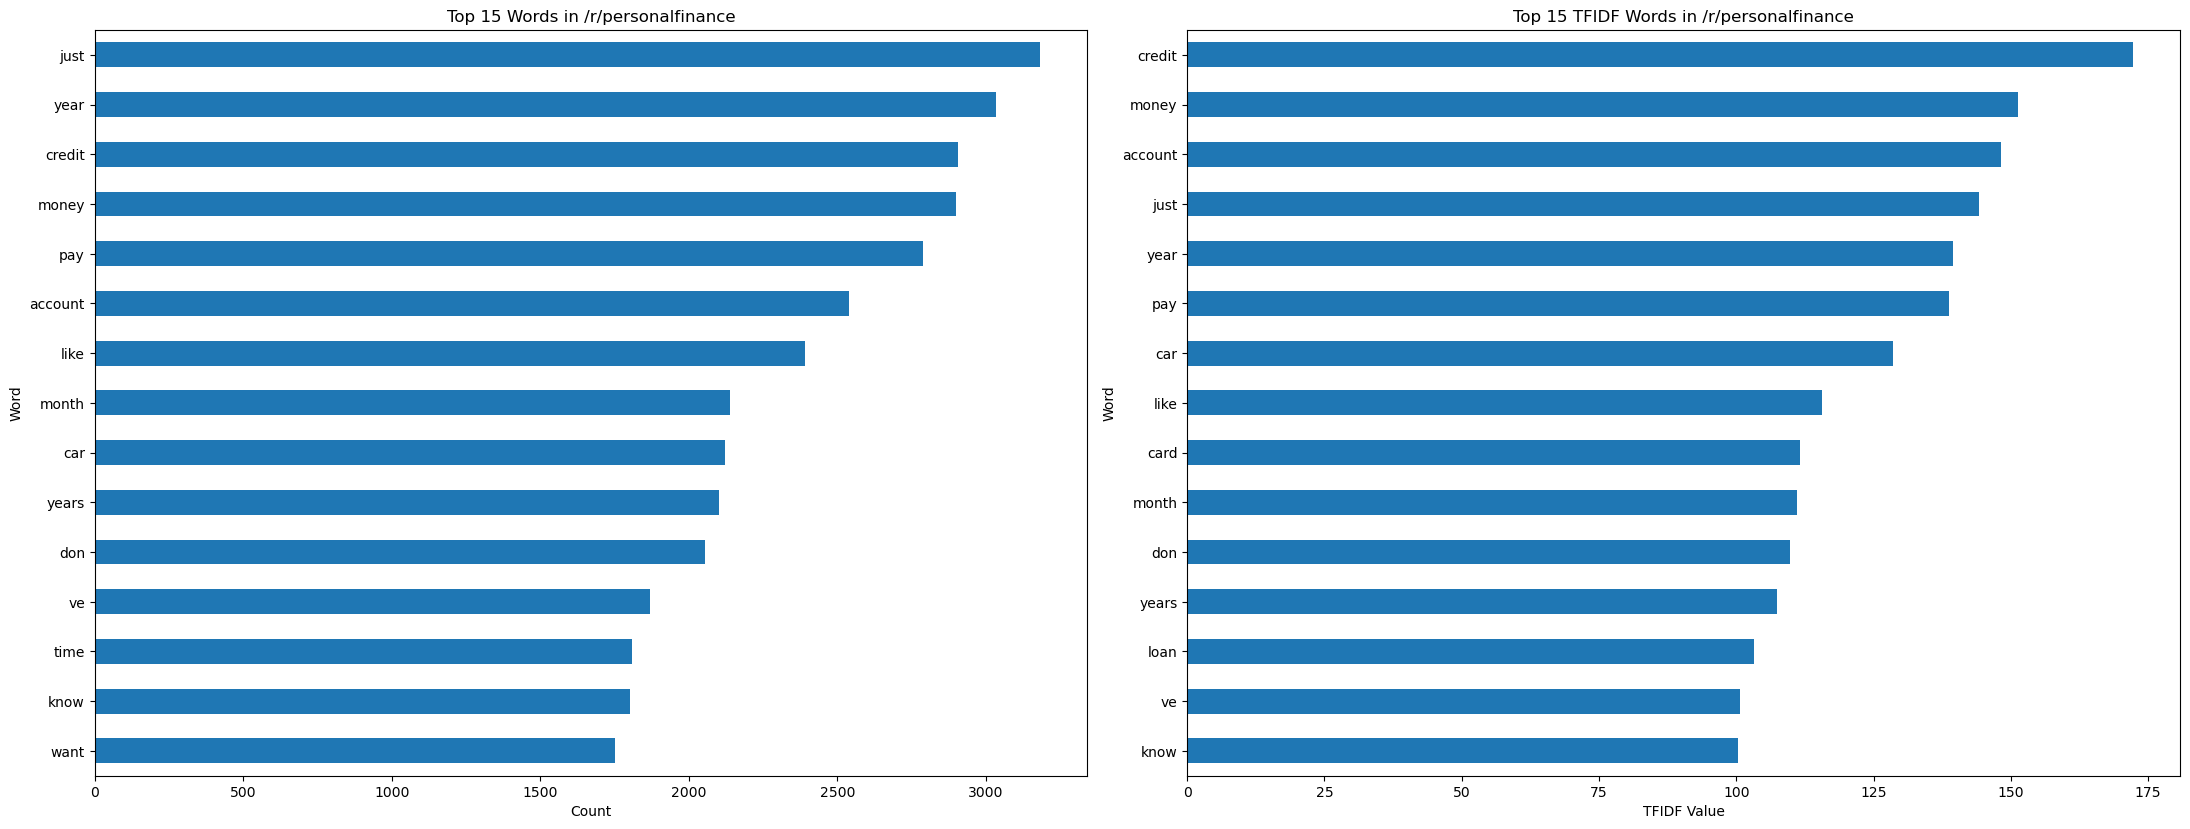

In [281]:
# Explore CountVectorizer token counts in /r/personalfinance
words_cvec_pf = pd.DataFrame(cvec.fit_transform(df[df.subreddit=='personalfinance'].selftext).todense(),
                       columns=cvec.get_feature_names_out())
word_counts_cvec_pf = words_cvec_pf.sum(axis=0)

# Explore TfidfVectorizer token counts in /r/personalfinance
words_tfidf_pf = pd.DataFrame(tfidf.fit_transform(df[df.subreddit=='personalfinance'].selftext).todense(),
                       columns=tfidf.get_feature_names_out())
word_counts_tfidf_pf = words_tfidf_pf.sum(axis=0)

# Plot top 15 words
plt.figure(figsize=(22,16), facecolor='white')

plt.subplot(2,2,1)
word_counts_cvec_pf.sort_values().tail(15).plot(kind='barh')
plt.title('Top 15 Words in /r/personalfinance')
plt.xlabel('Count')
plt.ylabel('Word')

plt.subplot(2,2,2)
word_counts_tfidf_pf.sort_values().tail(15).plot(kind='barh')
plt.title('Top 15 TFIDF Words in /r/personalfinance')
plt.xlabel('TFIDF Value')
plt.ylabel('Word')

plt.tight_layout()

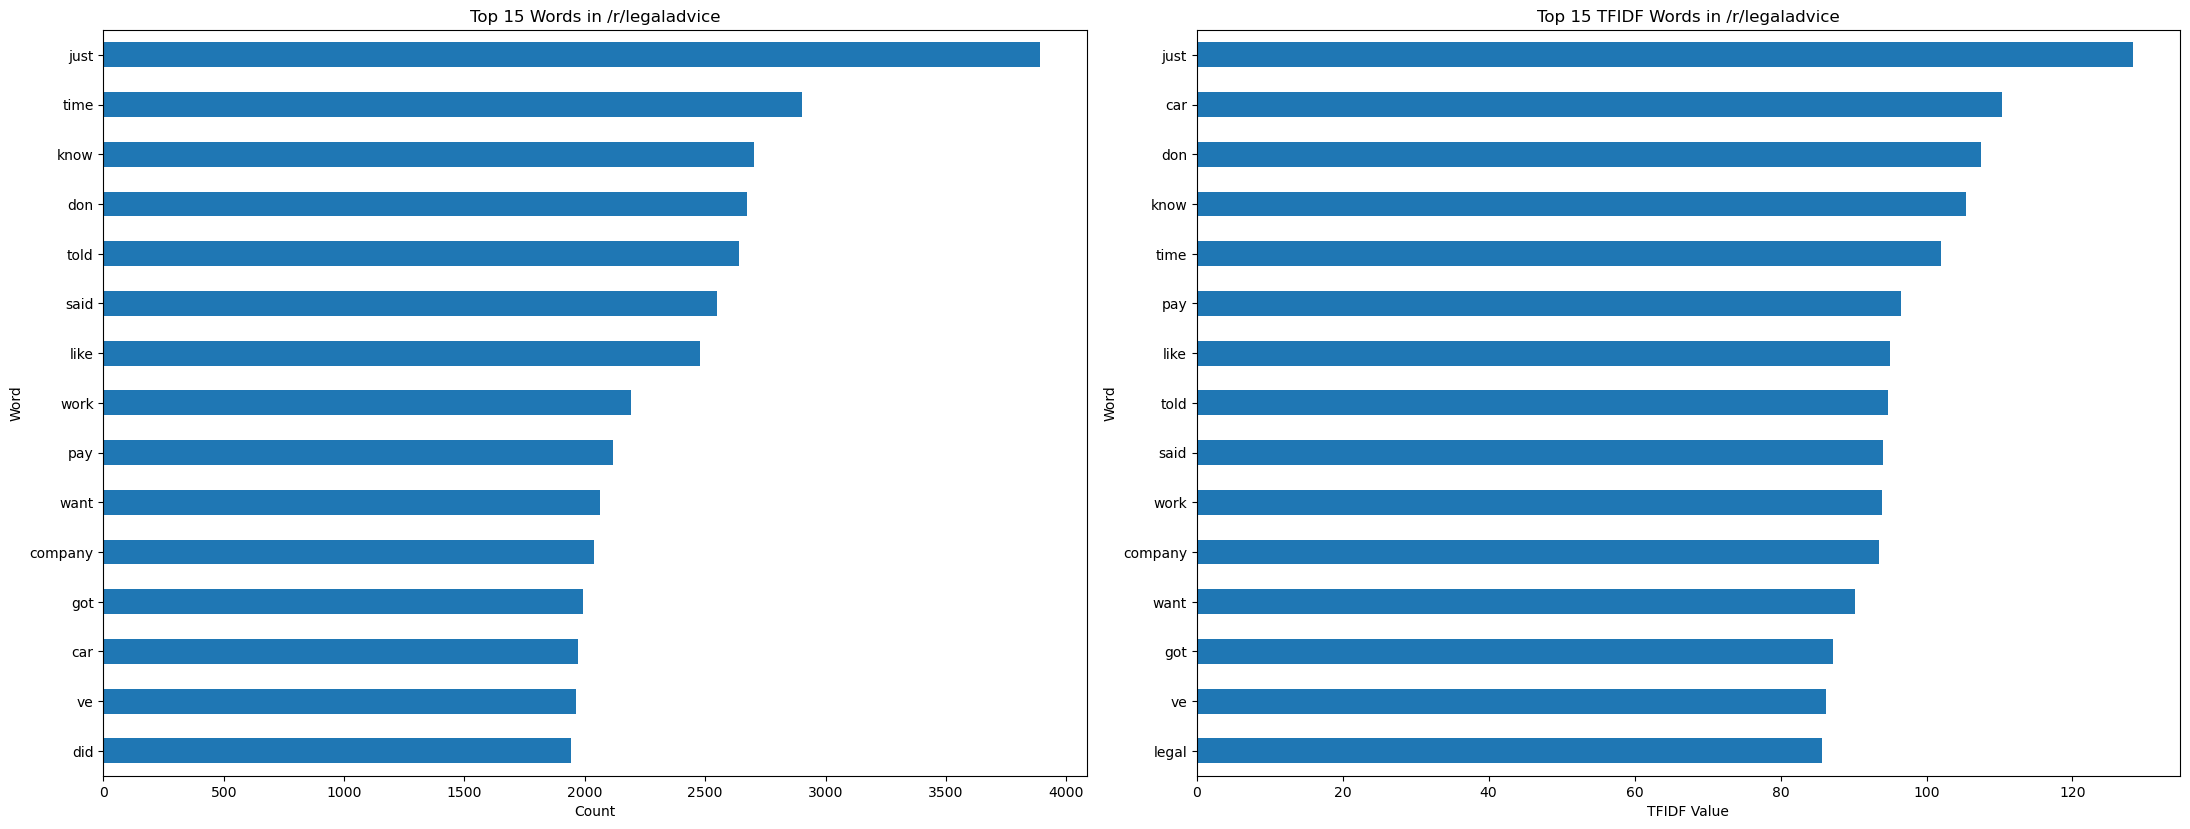

In [48]:
# Explore CountVectorizer token counts in /r/legaladvice
words_cvec_la = pd.DataFrame(cvec.fit_transform(df[df.subreddit=='legaladvice'].selftext).todense(),
                       columns=cvec.get_feature_names_out())
word_counts_cvec_la = words_cvec_la.sum(axis=0)

# Explore TfidfVectorizer token counts in /r/legaladvice
words_tfidf_la = pd.DataFrame(tfidf.fit_transform(df[df.subreddit=='legaladvice'].selftext).todense(),
                       columns=tfidf.get_feature_names_out())
word_counts_tfidf_la = words_tfidf_la.sum(axis=0)

# Plot top 15 words
plt.figure(figsize=(22,16), facecolor='white')

plt.subplot(2,2,1)
word_counts_cvec_la.sort_values().tail(15).plot(kind='barh')
plt.title('Top 15 Words in /r/legaladvice')
plt.xlabel('Count')
plt.ylabel('Word')

plt.subplot(2,2,2)
word_counts_tfidf_la.sort_values().tail(15).plot(kind='barh')
plt.title('Top 15 TFIDF Words in /r/legaladvice')
plt.xlabel('TFIDF Value')
plt.ylabel('Word')

plt.tight_layout()

In [ ]:
# Explain which words are the most commonly used

In [49]:
df['subreddit'] = df['subreddit'].map({'personalfinance': 0, 'legaladvice':1})

In [50]:
df.tail()

,subreddit,selftext
11923,1,So my sister (now 31) got married to her husba...
11924,1,Not sure if this is the right place since I'm ...
11925,1,My wife has cancer and the doctor told her to ...
11926,1,My Landlord's been pretty horrible throughout ...
11927,1,"Apologies if text is messed up, I’m using mobi..."


In [131]:
X = df['selftext']
y = df['subreddit']

In [132]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [133]:
y.value_counts(normalize = True)

1    0.500042
0    0.499958
Name: subreddit, dtype: float64

In [134]:
y_test.value_counts(normalize=True)

0    0.5
1    0.5
Name: subreddit, dtype: float64

In [308]:
# Random Forest Classifier

rf_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [309]:
cross_val_score(rf_pipe, X_train, y_train, cv=5).mean()

0.8951322048119875

In [310]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('rf', RandomForestClassifier())])

In [311]:
print('Random Forest Classifier')
print('Train score:', rf_pipe.score(X_train, y_train))
print('Test score:', rf_pipe.score(X_test, y_test))

Random Forest Classifier
Train score: 0.9988737329495683
Test score: 0.8983739837398373


______________________________________________

In [171]:
# Multinomial Naive Bayes Classifier

mnb_pipe = Pipeline([
  ('cvec', CountVectorizer()),
    ('nb', MultinomialNB()),
])

In [172]:
cross_val_score(mnb_pipe, X_train, y_train, cv=5).mean()

0.9156551223738868

In [173]:
mnb_pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('nb', MultinomialNB())])

In [174]:
print('Multinomial naive Bayes classifier')
print('Train score:', mnb_pipe.score(X_train, y_train))
print('Test score:', mnb_pipe.score(X_test, y_test))

Multinomial naive Bayes classifier
Train score: 0.934926792641722
Test score: 0.9192073170731707


________________________________

In [175]:
# Logistic Regression Model

lr_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression()),
])

In [176]:
cross_val_score(lr_pipe, X_train, y_train, cv=5).mean()

C:\Users\nurha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\nurha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.9052699551737984

In [177]:
lr_pipe.fit(X_train, y_train)

C:\Users\nurha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('cvec', CountVectorizer()), ('lr', LogisticRegression())])

In [178]:
print('Logistic Regression Model')
print('Train score:', lr_pipe.score(X_train, y_train))
print('Test score:', lr_pipe.score(X_test, y_test))

Logistic Regression Model
Train score: 0.99712176198223
Test score: 0.9103150406504065


Model | Train Score | Test Score
--- |--- | ---
Random Forest | 0.998 | 0.898
MultiNomial Naive Bayes | 0.934 | 0.919
Logistic Regression Model | 0.997 | 0.910




<b>Which performed better?</b> 
- The Multinomial naive Bayes classifier performed slightly better than the Logistic Regression Model and Random Forest therefore it is chosen to be the baseline.

In [239]:
# Choose which classifier is better to be the baseline to explore its parameters
pipe_cv = Pipeline([
    ('cv', CountVectorizer()),
    ('nb', MultinomialNB()),
])


params_grid_cv = {
    'cv__stop_words' : [None, 'english'],
    'cv__ngram_range' : [(1,1), (1,2)],
    'cv__max_df' : [1.0, 0.95],
    'cv__min_df' : [1, 2],
    'cv__max_features' : [2000, 2250, 2500]
}

In [240]:
gs = GridSearchCV(pipe_cv, param_grid=params_grid_cv, verbose=1)

In [241]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cv__max_features': [2000, 2250, 2500],
                         'cv__ngram_range': [(1, 1), (1, 2)],
                         'cv__stop_words': [None, 'english']},
             verbose=1)

In [298]:
print('Train score:', gs.score(X_train, y_train))
print('Test score:', gs.score(X_test, y_test))

Train score: 0.916030534351145
Test score: 0.9141260162601627


In [291]:
gs_pred = gs.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, gs_pred).ravel()

spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.8821138211382114


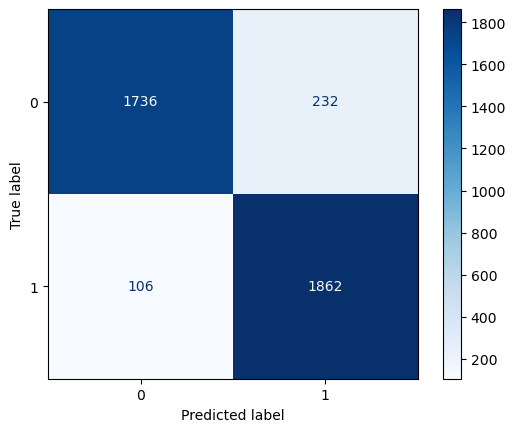

In [213]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

In [247]:
pipe_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [248]:
params_grid_tfidf = {
    'tfidf__stop_words' : [None, 'english'],
    'tfidf__ngram_range' : [(1,1), (1,2)],
    'tfidf__max_features' : [2000, 2250, 2500]
}

In [249]:
gs_tfidf = GridSearchCV(pipe_tfidf, 
                       param_grid=params_grid_tfidf, 
                       verbose=1)

In [250]:
gs_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tfidf__max_features': [2000, 2250, 2500],
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__stop_words': [None, 'english']},
             verbose=1)

In [297]:
print('Train score:', gs_tfidf.score(X_train, y_train))
print('Test score:', gs_tfidf.score(X_test, y_test))

Train score: 0.9197847578525842
Test score: 0.9153963414634146


In [290]:
gs_pred = gs_tfidf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, gs_pred).ravel()

spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.8861788617886179


C:\Users\nurha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


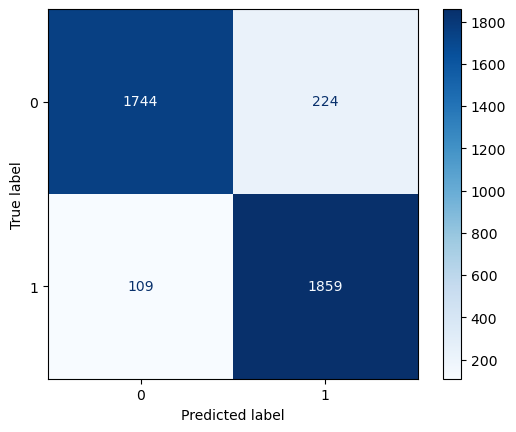

In [293]:
plot_confusion_matrix(gs_tfidf, X_test, y_test, cmap='Blues', values_format='d');

## 4. Evaluation <a class="anchor" id="Chapter4"></a>

In [292]:
y_pred = mnb_pipe.predict(X_test)

pd.DataFrame(confusion_matrix(y_test, y_pred),
            columns=['predict r/personalfinance', 'predict r/legaladvice'],
            index=['actual r/personalfinance', 'actual r/legaladvice'])

,predict r/personalfinance,predict r/legaladvice
actual r/personalfinance,1750,218
actual r/legaladvice,100,1868


In [294]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('Accuracy: {}'.format(round((tp+tn)/(tp+fp+tn+fn),4)))
print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
print('Precision: {}'.format(round(tp/(tp+fp),4)))
print('Recall: {}'.format(round(tp/(tp+fn),4)))
print('Specificity: {}'.format(round(tn/(tn+fp),4)))

Accuracy: 0.9192
Misclassification rate: 0.0808
Precision: 0.8955
Recall: 0.9492
Specificity: 0.8892


- The model correctly predicts 91.9% of observations.
- r/legaladvice, we have 89.5% of them correctly classified.
- r/legaladvice, the model has 94.9% of them correctly classified.
- r/personalfinance, the model has 88.9% of them correctly classified.


Error analysis:

Since the focus is on creating articles for their new venture into legal matters. It is more tolerable to predict personal finance wrongly as compared to legal advice. Therefore type II error here is more dangerous than Type 1 Error.

## 5. Conclusion <a class="anchor" id="Chapter5"></a>

- The Multinomial Naive Bayes classifier performed well with a test accuracy score of 91.9%.


- Ways to improve future models:
1. Collection of more data points for modelling.
2. Tuning of hyperparameters will help with the accuracy of the train and test score.
3. Optimize other ML models to see which is best.